In [69]:
import quandl
import datetime
import talib
from matplotlib import pyplot as plt
import bt
quandl.read_key()

In [91]:
start =  datetime.datetime(2017,1,1)

end = datetime.date.today() 

stock_data = quandl.get("WIKI/AAPL", start_date = start, end_date = end)

In [92]:
short_period = 12
long_period = 50

In [93]:
EMA_short = talib.EMA(stock_data['Close'], timeperiod=short_period).to_frame()
EMA_short = EMA_short.rename(columns={0: 'Close'})
EMA_short

,Close
Date,
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN
2017-01-06,NaN
2017-01-09,NaN
...,...
2018-03-21,176.103014
2018-03-22,174.986397
2018-03-23,173.440797


In [94]:
EMA_long = talib.EMA(stock_data['Close'], timeperiod=long_period).to_frame()
EMA_long = EMA_long.rename(columns={0: 'Close'})
EMA_long

,Close
Date,
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN
2017-01-06,NaN
2017-01-09,NaN
...,...
2018-03-21,173.303893
2018-03-22,173.129034
2018-03-23,172.807895


In [95]:
signal = EMA_long.copy()
signal[EMA_long.isnull()] = 0
signal[EMA_short > EMA_long] = 1
signal[EMA_short < EMA_long] = -1
signal

,Close
Date,
2017-01-03,0.0
2017-01-04,0.0
2017-01-05,0.0
2017-01-06,0.0
2017-01-09,0.0
...,...
2018-03-21,1.0
2018-03-22,1.0
2018-03-23,1.0


In [96]:
transition = signal[signal['Close'].diff() != 0] 
buy_signal = transition[transition['Close'] == 1]
sell_signal = transition[transition['Close'] == -1]

In [97]:
long_index = buy_signal.index
buy_position = stock_data[stock_data.index.isin(long_index)]
short_index = sell_signal.index
sell_position = stock_data[stock_data.index.isin(short_index)]

<ipython-input-98-3ad514fd0def>:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


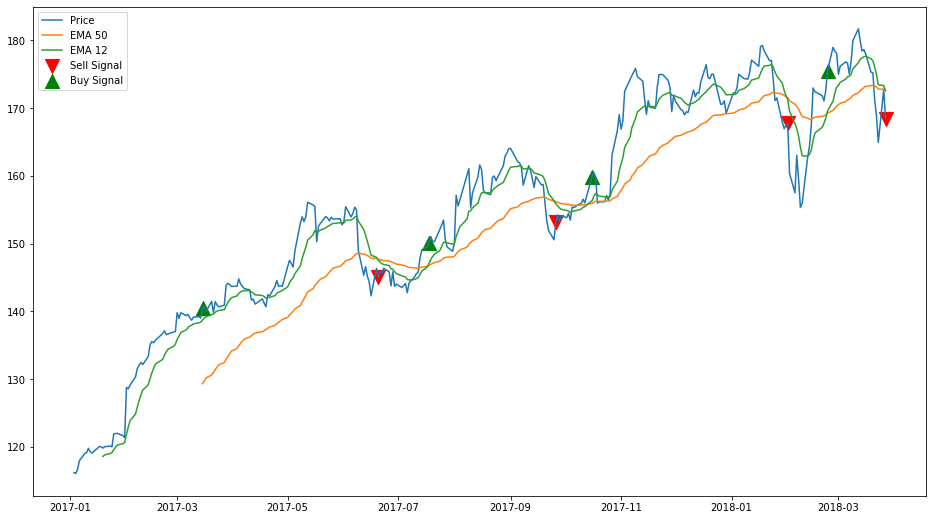

In [98]:
plt.figure(figsize=(16,9))
plt.plot(stock_data['Close'],label="Price")
plt.plot(EMA_long['Close'],label=f'EMA {long_period}')
plt.plot(EMA_short['Close'],label=f'EMA {short_period}')
plt.scatter(sell_position.index,sell_position['Close'],label="Sell Signal",marker="v",s=200,c="r")
plt.scatter(buy_position.index,buy_position['Close'],label="Buy Signal",marker="^",s=200,c="g")
plt.legend()
plt.show()

<ipython-input-99-ac1f92ba3955>:11: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


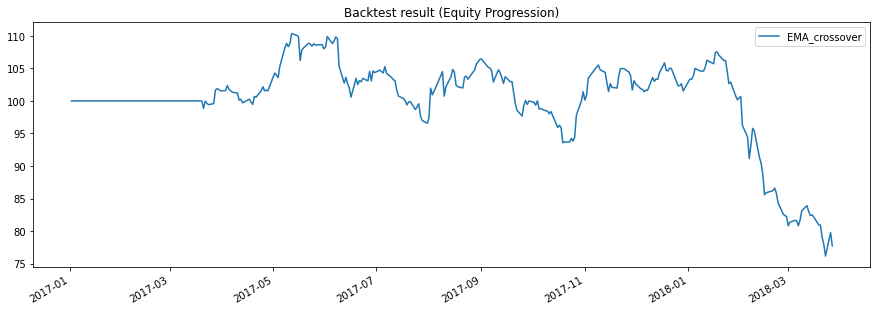

In [99]:
bt_strategy = bt.Strategy('EMA_crossover',
                            [   bt.algos.RunWeekly(),
                                bt.algos.WeighTarget(signal),
                                bt.algos.Rebalance()
                            ]
                         )

bt_backtest = bt.Backtest(bt_strategy, stock_data['Close'].to_frame())
bt_result = bt.run(bt_backtest)
bt_result.plot(title='Backtest result (Equity Progression)')
plt.show()

In [100]:
bt_result.display()

Stat                 EMA_crossover
-------------------  ---------------
Start                2017-01-02
End                  2018-03-27
Risk-free rate       0.00%

Total Return         -22.26%
Daily Sharpe         -1.01
Daily Sortino        -1.53
CAGR                 -18.52%
Max Drawdown         -30.97%
Calmar Ratio         -0.60

MTD                  -5.49%
3m                   -24.04%
6m                   -22.31%
YTD                  -23.43%
1Y                   -21.94%
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  -18.52%

Daily Sharpe         -1.01
Daily Sortino        -1.53
Daily Mean (ann.)    -18.84%
Daily Vol (ann.)     18.74%
Daily Skew           -0.06
Daily Kurt           3.17
Best Day             4.75%
Worst Day            -4.42%

Monthly Sharpe       -0.81
Monthly Sortino      -1.07
Monthly Mean (ann.)  -18.76%
Monthly Vol (ann.)   23.17%
Monthly Skew         -0.80
Monthly Kurt         2.27
Best Month           10.18%
Worst Month 